# Overview
The adiabatic transport code contains three python files

**AE_math.py**
contains wrappers for basic mathematical tools that are used in the rest of the code.

**AE_classes.py**
This contains classes that are used in the calculations, most notably the classes *Electrode*, *Device* and *Potential*.

**AE_methods.py** 
This file contains the computationally heavy methods required to actually calculate currents using the dynamical expansion, and to calculate the Wigner transforms of self-energies. 

The main work-horse of the code is the function AE_methods.calc_current() which does not only calculate current, but also Green's functions, densities etc. To use the function, the device, electrodes, potential and a time-grid must be specified. See the help-function below

In [2]:
import numpy as np
import AE_math
import AE_classes
import AE_methods

help(AE_methods.calc_current)

Help on function calc_current in module AE_methods:

calc_current(T, Device, Electrode_L, Electrode_R, order=2, eta=None, omega=None, nyquist_damping=5, calc_density=False, side='both', save_arrays='none', name=None, verbose=True)
    This function is the main workhorse of the code; using the adiabatic expansion technique, it calculates Greens functions and currents to a desired order (max 2) in the central time derivative.
    It uses the functions calc_Sigma_R and calc_Sigma_less to calculate the Wigner transforms of the specified self-energies for each electrode.
    
    The mandatory parameters are
    
    - T (scalar or np.array): list of times for which the calculation should be carried out
    
    - Device (instance of AE_classes.Device): An object specifying the device, which should include the time-dependent device Hamiltonian. See AE_classes.Device
    
    - Electrode_L (instance of AE_classes.Electrode): An object specifying the left electrode, see AE_classes.Electrode
 

The code can also be run on multiple processors using the function AE_methods.run_parallel; this function has the same argument syntax as calc_current, except that the desired number of jobs must be specified as the first argument.

# Example - a quantum dot connected to two electrodes

In [23]:
#First we specify the device
eps0 = 1.5 #dot on-site energy
kT = 0.1
dev = AE_classes.Device(H0=eps0,kT=kT)
mu_L = 0
mu_R = 0
#Let us assume that the left electrode is in the wide-band limit, and the right electrode self-energy is a Lorentzian

#Define left electrode
Gamma_L = 1/2
elec_L = AE_classes.Electrode(Gamma_L,kT=kT,mu=mu_L)


#Define right electrode
def Gamma_R(x):
    return 1/(x**2 + 1)


elec_R = AE_classes.Electrode(Gamma_R,kT,mu=mu_R)

Defaulting to setting: bandwidth = [-5,5].


Note that a warning is printed out - this is because the support of the right-electrode self-energy is in principle infinite. In the code, energy integrals are carried out which have to be truncated at some point. Hence, for best performance, the bandwidth of the electrode should be specified.

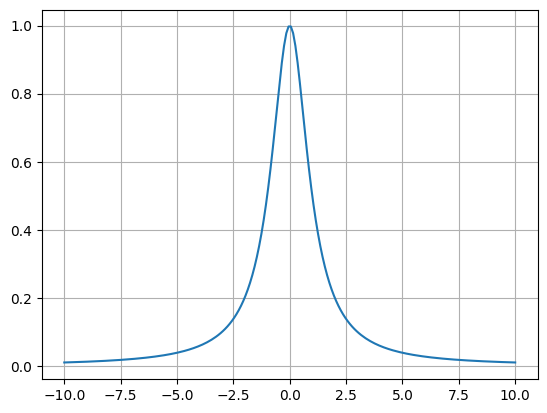

In [24]:
elec_R.bandwidth = [-10,10]
omega = np.linspace(-10,10,200)
import matplotlib.pyplot as plt
plt.plot(omega,Gamma_R(omega))
plt.grid()


Specifying the bandwidth as [-10,10] seems pretty reasonable in this case. 

We can now calculate the current - but since we didn't specify a potential or the chemical potentials of the electrodes (which default to 0), the result should be pretty boring.

In [25]:
T = np.linspace(-50,50,101)
out = AE_methods.calc_current(T,dev,elec_L,elec_R)
print(out.keys())

calc_current total calculated in 1.07 seconds
dict_keys(['J0_L', 'J0_R', 'J1_L', 'J1_R', 'J2_L', 'J2_R'])


The output dictionary contains the left- and right currents calculated to 0, 1st and 2nd order. 

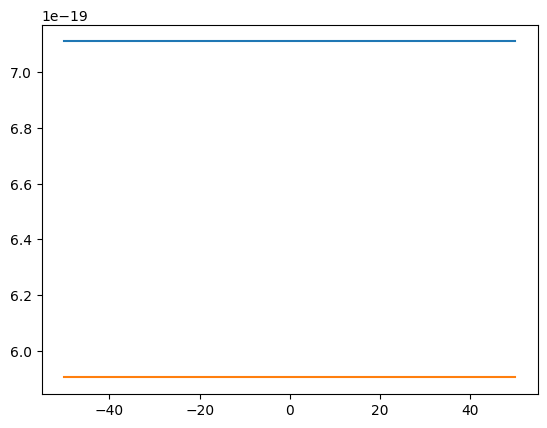

In [26]:
plt.plot(T,out['J0_L'] + out['J1_L']+ out['J2_L'])
plt.plot(T,out['J0_R'] + out['J1_R']+ out['J2_R'])


So numerically zero current flows - seems reasonable.

Now, we want to specify a potential. This is specified by the AE_classes.Potential class. 

In [28]:
help(AE_classes.Potential)

Help on class Potential in module AE_classes:

class Potential(builtins.object)
 |  Potential(function, support=[-inf, inf], Range=[None, None], derivative=None, antiderivative=None)
 |  
 |  Class for handling external potentials.
 |  
 |  The raison d'etre is the fact that in calculating the Wigner transforms of electrode self-energies,
 |  an integral over the entire external potential must be carried out.
 |  To ensure that this is done correctly, the program needs to know the support of the potential, and 
 |  this is a parameter that may be specified in this class. 
 |  By optionally specifiying additional parameters such as the Range of the potential or 
 |  analytical expressions for its derivative or antiderivative, computation time may be improved significantly.
 |  
 |  Example use:
 |      pot = Potential(np.cos, support=[0, 2*np.pi],Range=[-1,1],antiderivative = np.sin)
 |      t = np.linspace(-np.pi, np.pi,100)
 |      V = pot(t)
 |  
 |      V will now be an array with t

calc_current total calculated in 1.90 seconds


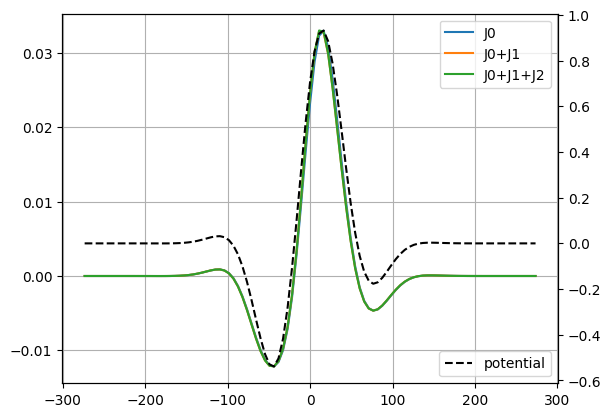

In [62]:
#Let us specify the potential to vary as a THz-like pulse.
from scipy.constants import hbar, eV
to_ps = hbar/eV*1e12
freq = 10*to_ps #10 THz
zeta = .3/freq  #pulse width in periods
phi= - np.pi/4 #carrier-envelope phase shift
amplitude = 1

def THz_pulse(t):
    carrier = np.sin(2*np.pi*freq*t-phi)
    envelope = amplitude*np.exp(-t**2/(2*zeta**2))
    pulse= carrier * envelope
    return pulse
T = np.linspace(-6*zeta,6*zeta,101)
dT = (T.max() - T.min()) / (T.size - 1)
pot_L = AE_classes.Potential(THz_pulse, support=[-5*zeta, 5*zeta],Range=[-amplitude,amplitude])
pot_L.get_numerical_antiderivative(spline_density=10/dT)
elec_L.potential = pot_L




out2 = AE_methods.calc_current(T,dev,elec_L,elec_R)
fig,ax = plt.subplots()
ax.plot(T,out2['J0_L'],label='J0')
ax.plot(T,out2['J0_L']+out2['J1_L'],label='J0+J1')
ax.plot(T,out2['J0_L']+out2['J1_L']+out2['J2_L'],label='J0+J1+J2')
ax2 = ax.twinx()
ax2.plot(T,pot_L(T),ls='dashed',color='k',label='potential')
ax.grid()
ax.legend(loc='upper right')
ax2.legend(loc='lower right')
#plt.ylim([-0.3,0.3])

For this problem, all the curves are on top of each other - evidently the problem can easily be modeled adiabatically. Try to increase the frequency, and see when the non-adiabatic effects start to enter.

Note that after specifying the potential, we call the function pot_L.get_numerical_antiderivative() which pre-computes the antiderivative of the potential. This **significantly** speeds up computation time, and is always recommended. The antiderivative can also be specified analytically, if this is known, but then remember to make sure that it satisfies the appropriate boundary conditions consistent with the specified support. 

The function pot_L.get_numerical_antiderivative() approximates the anti-derivative using cubic splines. By default, 20.0 splines are used per unit of time. For extremely slow perturbations this should be reduced to improve computation speed, by specifying the spline_density parameter.


One can also save more information about the system when calling the calc_current function. By specifying save_arrays = 'all', all internal arrays (e.g. green's functions, current matrices) are saved. To save memory for large systems, one can also specify save_arrays = 'diag' to only save diagonal elements. 

To calculate the electron occupation in the device, one should specify the option calc_density = True

In [70]:
out3 = AE_methods.calc_current(T,dev,elec_L,elec_R,save_arrays='all',calc_density = True)
print(out3.keys()) 
#vocabulary: Pi - current matrices, G -  green functions, density - electron occupation (trace of Glesser integrated over energy)
#number specifies the perturbative order of the calculation.
print('\n')
print('shape of G: ', out3['G0_R'].shape)
print('The shape of the internal arrays, e.g. green\'s functions have the meaning (Time, energy, matrix indices)')

calc_current total calculated in 1.55 seconds
dict_keys(['G0_R', 'G0_less', 'G1_R', 'G1_less', 'G2_R', 'G2_less', 'Pi0_L', 'Pi1_L', 'Pi2_L', 'Pi0_R', 'Pi1_R', 'Pi2_R', 'J0_L', 'J0_R', 'J1_L', 'J1_R', 'J2_L', 'J2_R', 'density0', 'density1', 'density2'])


shape of G:  (101, 2001, 1, 1)
The shape of the internal arrays, e.g. green's functions have the meaning (Time, energy, matrix indices)


# A more complicated system - double quantum dot

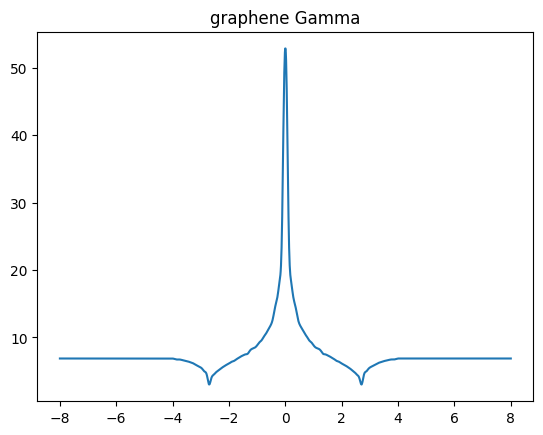

In [118]:
Delta = 2
eps0 = 0
eps1 = 1/2
V = 1
H0 = np.array([[eps0,V],[V,eps1]]) #Hamiltonian of device in the absence of external potentials

Ht = lambda t : Delta * THz_pulse(t) * np.identity(2) #Part of device Hamiltonian that depends on external potential. Here, both on-site elements shift with the pulse

dev = AE_classes.Device(H0=H0,Ht=Ht,kT=kT)

#Let us model the left electrode as a graphene sheet which couples only to the first of the two sites in the DQD.
#We load the file graphene_SE.npy which contains the self-energy obtained from a tight-binding calculation evaluated at 100 energy points
Ev = np.linspace(-4,4,100)
graphene_SE = np.load('graphene_SE.npy')
t = -2.7
SE00 = graphene_SE[:,0,0] + (-t - graphene_SE[:,0,1]) * 1/(Ev - 0.0 - graphene_SE[:,1,1]) * (-t - graphene_SE[:,1,0])

#The self-energy must be callable. Thus we interpolate the calculated self-energy using cubic splines.
#Multiplying by the matrix np.array([[1,0],[0,0]]) signals that the left electrode couples only to the central site.

Gamma_graphene =  AE_math.Spline(Ev,-2*SE00.imag.reshape(-1,1,1)*np.array([[1,0],[0,0]]),bc_type='constant',MatrixFunction=True)
#AE_math.Spline: the options bc_type specify that outside the interpolated range, constant boundary conditions are used. MatrixFunction signifies that the returned output is a matrix.
omega = np.linspace(-8,8,1500)
plt.title('graphene Gamma')
plt.plot(omega,Gamma_graphene(omega)[:,0,0])



#define the graphene electrode
#the optional parameter coupling_index allows the user to specify which indices of the self-energy can ever be non-zero. This allows for a faster computation
graphene = AE_classes.Electrode(Gamma_graphene,kT=kT,mu=0,potential=pot_L,bandwidth=[-8,8],coupling_index=np.array([[1,0],[0,0]]))

#Let us take the right electrode to only couple to the second site, and be in the wide-band limit.
#Let us also assume that it has a constant bias over it, which we can vary

bias_right = 1/2
pot_R = AE_classes.Potential(bias_right)
pot_R.get_numerical_antiderivative(spline_density=10/dT)

Gamma_R = 1/2 * np.array([[0,0],[0,1]])
elec_R = AE_classes.Electrode(Gamma_R,kT=kT,mu=0,potential=pot_R)

#So now we have a system where a double quantum dot is connected to a graphene electrode on the one side, and 
# a WBL electrode on the other side. The DQD and the graphene are both modulated by the THz potential from before.

In [119]:
out4 = AE_methods.run_parallel(n_jobs=4,T=T,Device=dev,Electrode_L = graphene,Electrode_R = elec_R,omega=omega)

calc_current total calculated in 3.79 seconds
calc_current total calculated in 3.98 seconds
calc_current total calculated in 4.22 seconds
calc_current total calculated in 4.73 seconds


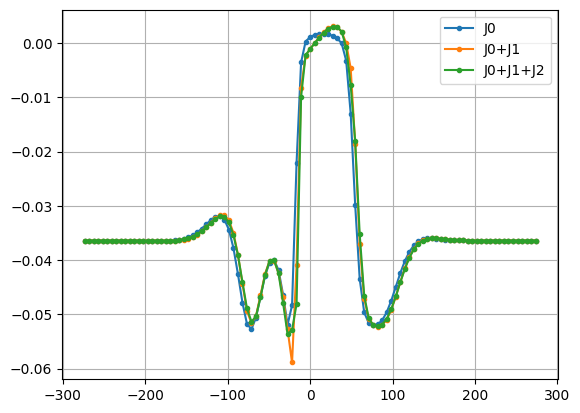

In [124]:
plt.plot(T,out4['J0_L'],label='J0',marker='.')
plt.plot(T,out4['J0_L']+ out4['J1_L'],label='J0+J1',marker='.')
plt.plot(T,out4['J0_L']+ out4['J1_L']+out4['J2_L'],label='J0+J1+J2',marker='.')
plt.legend()
plt.grid()